# Neural & Behavioral Modeling - Week 11 (Exercises)
by Cheng-Kuang, Wu (r10922186@ntu.edu.tw)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gfi8zwth because the default path (/home/ckwu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.11.0
Device  0 : GeForce RTX 3090
Device  1 : GeForce RTX 3090
Current: Device  0


## 1 Fair Performance Evaluation (2 points)
We often compare and assess performances of different model architectures/parameters/hyperparameters. Note that the results are differnt even if you re-run exactly the same code block. This is primarily due to a non-fixed random number seed. Please:

(1) run the section 1.2 TEN times and report (a) min, (b) max, (c) mean, & (d) standard deviation of the TESTING accuracies. (2 points)

(2) try to fix the random number seeds in numpy & pytorch to see if you can obtain the same results every time in the section 1.2. (2 points)

### 1.0 CIFAR-10 dataset

In [4]:
# Load the dataset:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
train_set = CIFAR10(root='.', train=True, transform=transforms.ToTensor(), download=True)
train_data = t.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_set = CIFAR10(root='.', train=False, transform=transforms.ToTensor())
test_data = t.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


### 1.1 The model

In [9]:
# Make the model:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # = nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 6, 5) # in, out, kernel
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1   = nn.Linear(16*5*5, 120) 
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x): # functional expressions
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x

### 1.2 Training & Testing

In [13]:
import random
import pandas as pd

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    t.manual_seed(seed)
    if t.cuda.is_available():
        t.cuda.manual_seed(seed)
        t.cuda.manual_seed_all(seed)
    t.backends.cudnn.benchmark = False
    t.backends.cudnn.deterministic = True

def run_experiment(train_data, test_data, fix_seed: bool = False) -> float:
    if fix_seed:
        set_seeds(seed=42)

    model = Net()
    model = model.to(device)
    loss_fn = t.nn.CrossEntropyLoss()
    optimizer = t.optim.Adam(model.parameters())

    # Training:
    for e in range(2):
        for _, (X_train, Y_train) in enumerate(train_data, 0):
            X_train,Y_train = X_train.to(device),Y_train.to(device)
            Y_pred = model(X_train)
            loss = loss_fn(Y_pred, Y_train)
            model.zero_grad()
            loss.backward()
            optimizer.step()   
            Y_pred = model(X_train)
            Y_pred = t.max(Y_pred,1)[1]
        
    # Testing on a batch:
    dataiter = iter(test_data)
    X_test, Y_test = dataiter.next() # returning a batch
    X_test,Y_test = X_test.to(device),Y_test.to(device)
    with t.no_grad():
        Y_pred = model(X_test)
        Y_pred = t.max(Y_pred,1)[1]
        test_acc = (Y_pred==Y_test).sum().item()/Y_test.shape[0]

    return test_acc

Testing accuracy: 0.522


### 1.3 Your answers

#### 1.3.1 Run the section 1.2 TEN times and report (a) min, (b) max, (c) mean, & (d) standard deviation of the TESTING accuracies. (2 points)

In [14]:
n_experiments = 10
fix_seed = False

test_accs = list()
for i in range(n_experiments):
    test_acc = run_experiment(train_data, test_data, fix_seed)
    test_accs.append(test_acc)
    print(f"Experiment {i + 1}: testing accuracy = {test_acc:.3f}")

test_accs = pd.Series(test_accs)

Experiment 1: testing accuracy = 0.520
Experiment 2: testing accuracy = 0.517
Experiment 3: testing accuracy = 0.498
Experiment 4: testing accuracy = 0.570
Experiment 5: testing accuracy = 0.559
Experiment 6: testing accuracy = 0.506
Experiment 7: testing accuracy = 0.492
Experiment 8: testing accuracy = 0.536
Experiment 9: testing accuracy = 0.507
Experiment 10: testing accuracy = 0.507


In [23]:
stats = test_accs.describe()
print(f"Min = {stats['min']:.3f}; Max = {stats['max']:.3f}; Mean = {stats['mean']:.3f}; Standard deviation = {stats['std']:.3f}")

Min = 0.492; Max = 0.570; Mean = 0.521; Standard deviation = 0.026


#### 1.3.2 Try to fix the random number seeds in numpy & pytorch to see if you can obtain the same results every time in the section 1.2. (2 points)

In [25]:
n_experiments = 10
fix_seed = True

test_accs = list()
for i in range(n_experiments):
    test_acc = run_experiment(train_data, test_data, fix_seed)
    test_accs.append(test_acc)
    print(f"Experiment {i + 1}: testing accuracy = {test_acc:.3f}")

test_accs = pd.Series(test_accs)

Experiment 1: testing accuracy = 0.493
Experiment 2: testing accuracy = 0.493
Experiment 3: testing accuracy = 0.493
Experiment 4: testing accuracy = 0.493
Experiment 5: testing accuracy = 0.493
Experiment 6: testing accuracy = 0.493
Experiment 7: testing accuracy = 0.493
Experiment 8: testing accuracy = 0.493
Experiment 9: testing accuracy = 0.493
Experiment 10: testing accuracy = 0.493


In [26]:
stats = test_accs.describe()
print(f"Min = {stats['min']:.3f}; Max = {stats['max']:.3f}; Mean = {stats['mean']:.3f}; Standard deviation = {stats['std']:.3f}")

Min = 0.493; Max = 0.493; Mean = 0.493; Standard deviation = 0.000


## 2 Universal Approximation Theorem (4 points)

Please FAIRLY evaluate whether a deep network learns XOR more efficiently than a shallow network with the same number of model parameters. Please discuss why in either case.

### 2.0 XOR data

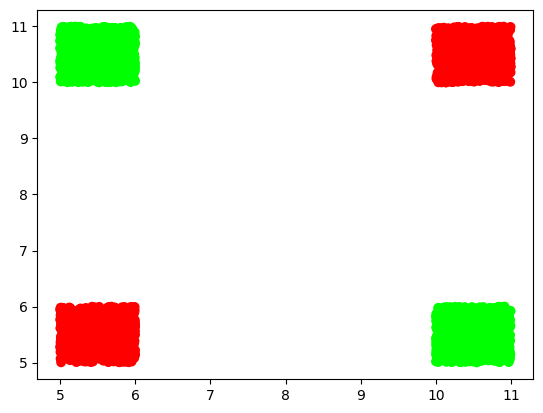

In [3]:
N=1000 # samples per cluster
XY=t.tensor([[5,5],[5,10],[10,5],[10,10]],dtype=t.float32) # 4 cluster centers
Z=t.tensor([0,1,1,0]) # category labels
t.cat([t.randn(2,1)+XY[0,0],t.randn(2,1)+XY[0,1]],1)
xy,z=t.zeros(4*N,2),t.zeros(4*N,dtype=t.int64)
for i in range(4):
    xy[i*N:(i+1)*N,]=t.rand(N,2)+XY[i,]
    z[i*N:(i+1)*N]=Z[i]
xy_np=xy.numpy()
z_np=z.numpy().astype(int)
cmap=np.array([[1,0,0],[0,1,0]])
scatter(xy_np[:,0],xy_np[:,1],color=cmap[z_np]);

#### 2.1 A shallow net with one hidden layer

In [57]:
# Number of free parameters: 2*H+H*2=48
def get_shallow_net() -> t.nn.Module:
    H = 12 # number of hidden units
    model = t.nn.Sequential(
        t.nn.Linear(2, H, bias=False),
        t.nn.BatchNorm1d(H),
        t.nn.ReLU(),
        t.nn.Linear(H, 2, bias=False),
        t.nn.Softmax(dim=1)
    )
    return model

#### 2.2 A "deep" net with three hidden layers

In [58]:
# Number of free parameters: 2*H+H*H+H*H+H*2=48
def get_deep_net() -> t.nn.Module:
    H = 4
    model = t.nn.Sequential(
        t.nn.Linear(2, H, bias=False),
        t.nn.BatchNorm1d(H),
        t.nn.ReLU(),
        t.nn.Linear(H, H,bias=False),
        t.nn.BatchNorm1d(H),
        t.nn.ReLU(),
        t.nn.Linear(H, H, bias=False),
        t.nn.BatchNorm1d(H),
        t.nn.ReLU(),
        t.nn.Linear(H, 2, bias=False),
        t.nn.Softmax(dim=1)
    )
    return model

### 2.3 Your answers

Because experiments vary from run to run, it is more reasonable to run experiments multiple times (100 times in my case) for both shallow and deep networks to compare their learning efficiency better.

In [48]:
from typing import List

def run_experiment(net_type: str, nepochs: int) -> List[float]:
    if net_type == "shallow":
        model = get_shallow_net()
    elif net_type == "deep":
        model = get_deep_net()
    else:
        raise ValueError()

    loss_fn = t.nn.CrossEntropyLoss()
    optimizer = t.optim.Adam(model.parameters())
    
    accs = list()
    for _ in range(nepochs):
        z_pred = model(xy)
        loss = loss_fn(z_pred,z)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        z_pred = model(xy) 
        z_pred = t.max(z_pred,1)[1]
        acc = (z_pred==z).sum().item()/xy.shape[0]
        accs.append(acc)

    return accs

def run_experiments(net_type: str, nepochs: int, nexperiments: int) -> np.ndarray:
    accs_l = list()

    for _ in range(nexperiments):
        accs = run_experiment(net_type, nepochs)
        accs_l.append(accs)

    mean_accs = np.array(accs_l).mean(axis=0)
    return mean_accs

mean_shallow_accs = run_experiments(net_type="shallow", nepochs=100, nexperiments=100)
mean_deep_accs = run_experiments(net_type="deep", nepochs=100, nexperiments=100)

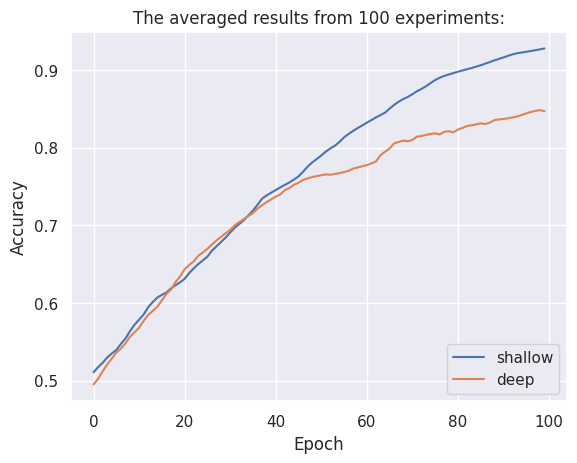

In [60]:
import seaborn as sns
sns.set_theme()

title("The averaged results from 100 experiments:")
xlabel("Epoch"); ylabel("Accuracy");
plot(mean_shallow_accs, label="shallow")
plot(mean_deep_accs, label="deep")
legend(loc="lower right");

### Discussion

We can see that with the same number of model parameters, **shallow** network learns more efficiently.

I think one of the reason is that deep networks have the problem of **gradient vanishing**. That is, "the gradients back-propagated to the layers closer to the input" tend to be much smaller than "the gradients of layers closer to the output", so the learning might be not so efficient in the earlier layers of deep networks.

Another reason may be what the teacher said in class, that is, it is harder for deep networks to learn **identity mappings**, which may be required to solve this XOR problem.